# Loading Dataset and Annotations

In this notebook we show how to load the data from the StyledCOCO dataset and how to overlay the huma-pose annotations with the images

In [1]:
import os
import sys
import json
from collections import defaultdict
from collections import OrderedDict

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

sys.path.append("..")

import models
import data
import data.data_processing as data_processing
from data.custom_transforms import Normalize, Resize
import lib.transforms as custom_transforms
import lib.visualizations as visualizations
import lib.utils as utils
import lib.metrics as metrics
import lib.loss as loss
import lib.nms as nms_lib
import lib.inference as inference
import lib.bounding_box as bbox
import lib.pose_parsing as pose_parsing 
from CONFIG import CONFIG
import CONSTANTS

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
test_exp = "test/experiment_2020-06-04_08-06-38"
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], test_exp)

In [31]:
data_path = CONFIG["paths"]["data_path"]
images_path = os.path.join(data_path, "images", "train")
original_imgs_path = os.path.join(data_path, "original_images", "train2017")
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_train.json")

In [30]:
COCO_KEYPOINT_INDEXES = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear',
    4: 'right_ear',
    5: 'left_shoulder',
    6: 'right_shoulder',
    7: 'left_elbow',
    8: 'right_elbow',
    9: 'left_wrist',
    10: 'right_wrist',
    11: 'left_hip',
    12: 'right_hip',
    13: 'left_knee',
    14: 'right_knee',
    15: 'left_ankle',
    16: 'right_ankle'
}

# Dataset

In [37]:
image_size = 600
exp_data = utils.load_experiment_parameters(test_exp)
exp_data["training"]["batch_size"] = 1
exp_data["dataset"]["dataset_name"] = "coco"
exp_data["dataset"]["image_size"] = image_size
exp_data["model"]["model_name"] = "HRNet"

In [38]:
_, valid_loader = data.load_dataset(exp_data=exp_data, train=False,
                                    validation=True, shuffle_train=True,
                                    shuffle_valid=False)

_, random_loader, _, dataset = data.load_dataset(exp_data=exp_data, train=False,
                                                 validation=True, shuffle_train=True,
                                                 shuffle_valid=True, get_dataset=True)


Heatmap size: [48 64]
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
Heatmap size: [48 64]
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [44]:
# iterator = iter(valid_loader)
# for i in range(1):
#     imgs, target, target_weight, metadata = iterator.next()

imgs, target, target_weight, metadata = next(iter(random_loader))

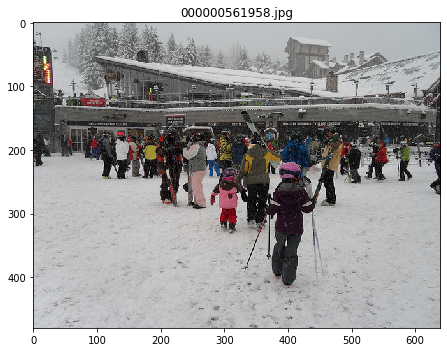

In [45]:
paths = metadata["image"]
img1 = cv2.imread(paths[0], cv2.IMREAD_COLOR)
# img2 = cv2.imread(paths[1], cv2.IMREAD_COLOR)
normalizer = Normalize(mean=(128, 128, 128), std=256)
img1 = normalizer(img1)
# img2 = normalizer(img2)
# full_imgs = np.array([img1, img2])
full_imgs = np.array([img1])
full_imgs = full_imgs.transpose(0,3,1,2)
full_imgs = torch.Tensor(full_imgs)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,5)
visualizations.visualize_image(np.array(full_imgs[0,:]), ax=ax, title=f"{paths[0].split('/')[-1]}")
# visualizations.visualize_image(np.array(full_imgs[1,:]), ax=ax[1], title=f"{paths[1].split('/')[-1]}")
plt.tight_layout()
plt.show()

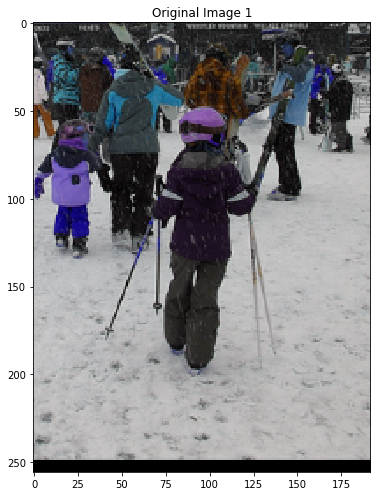

In [46]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
visualizations.visualize_image(np.array(imgs[0,:]), ax=ax, title="Original Image 1")
# visualizations.visualize_image(np.array(imgs[1,:]), ax=ax[1], title="Original Image 2")
plt.tight_layout()
plt.show()

# Models

In [47]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [48]:
# HRNet Model
hrnet = models.PoseHighResolutionNet(is_train=False)
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "HRnet", "pose_hrnet_w32_256x192.pth")
hrnet.load_state_dict(torch.load(pretrained_path))

<All keys matched successfully>

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
faster_rcnn = faster_rcnn.to(device)
hrnet = hrnet.to(device)
faster_rcnn = faster_rcnn.eval()
hrnet = hrnet.eval()

# Inference

In [50]:
output = hrnet(imgs.to(device).float())

In [51]:
target = target.cuda(non_blocking=True)
target_weight = target_weight.cuda(non_blocking=True)

In [52]:
loss_function = loss.PersonMSELoss()
loss_value = loss_function(output, target, target_weight).item()
print(f"Loss Value: {round(loss_value,5)}")

Loss Value: 0.00059


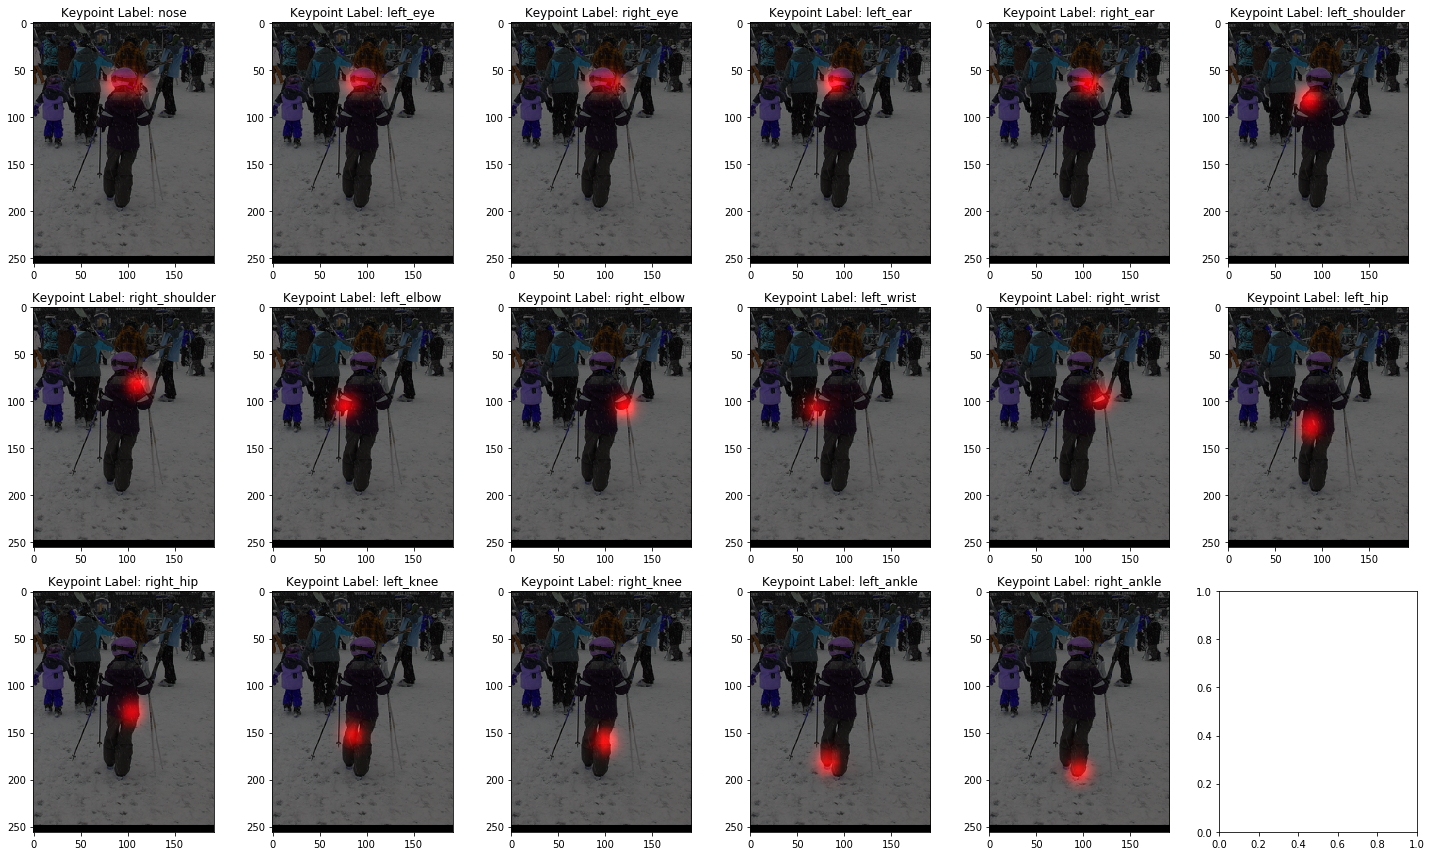

In [53]:
idx = 0
fig, ax = plt.subplots(3,6)
fig.set_size_inches(20,12)
scaled_heats = F.interpolate(output.clone().detach(), (256, 192), mode="bilinear",
                             align_corners=True)
for i in range(17):
    row = i // 6
    col = i% 6
    title = f"Keypoint Label: {COCO_KEYPOINT_INDEXES[i]}"
    visualizations.overlay_heatmap(heatmap=np.array(scaled_heats[idx,i,:].cpu()), img=np.array(imgs[idx,:].cpu()),
                                   ax=ax[row, col], title=title)
plt.tight_layout()
plt.show()

In [54]:
centers = metadata["center"].numpy()
scales = metadata["scale"].numpy()
score = metadata["score"].numpy()

keypoints, max_vals, coords = pose_parsing.get_final_preds_hrnet(scaled_heats.cpu().numpy(), centers, scales)

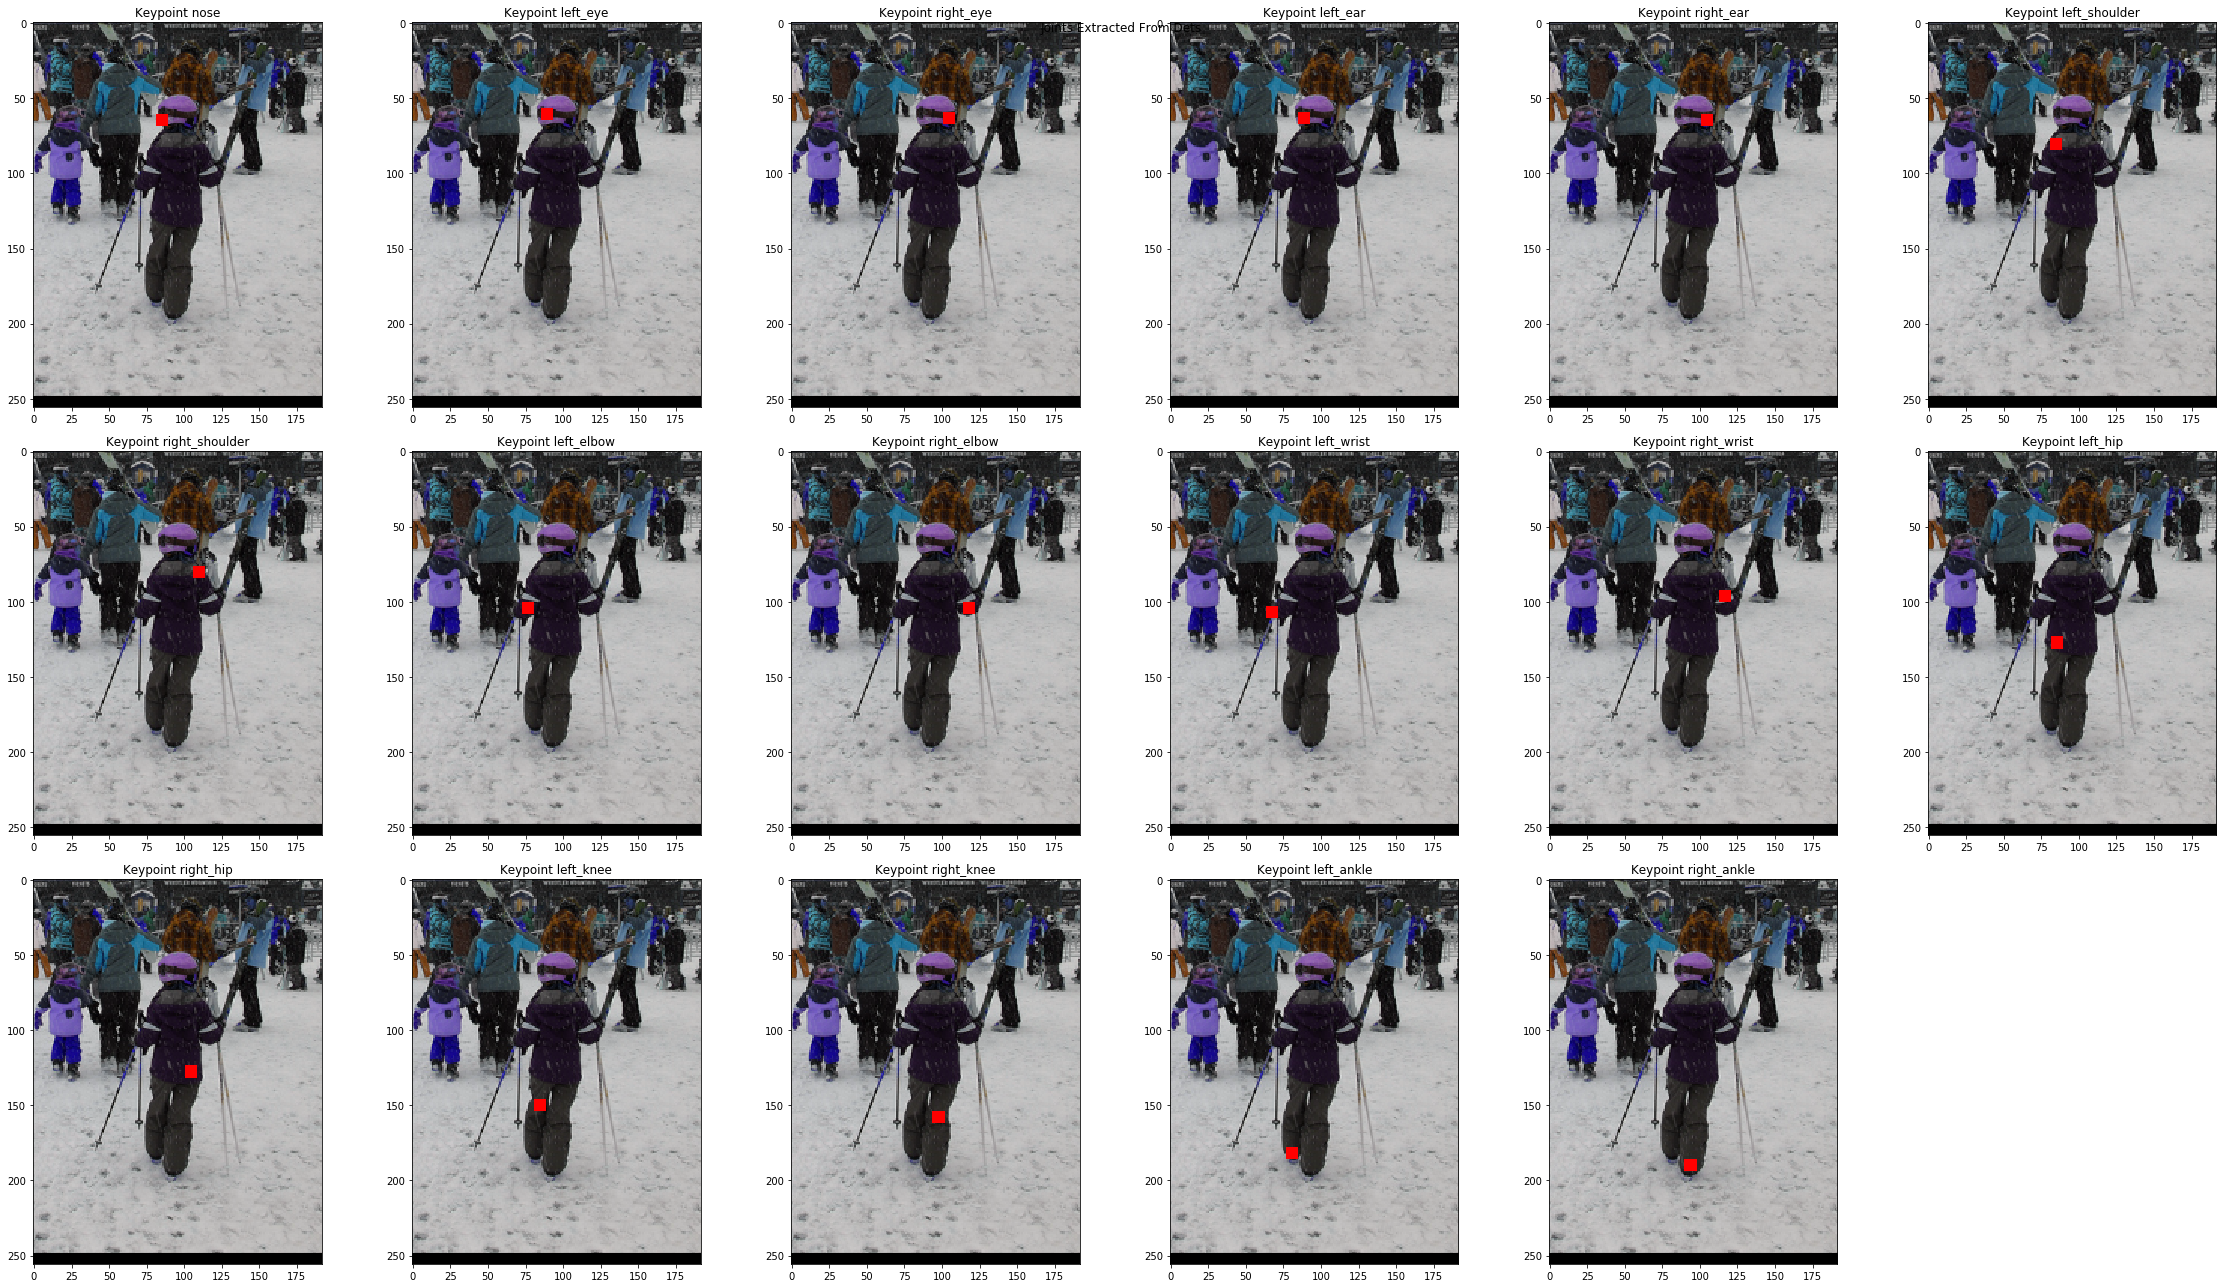

In [55]:
idx = 0
plt.figure(figsize=(32, 18))
zoom = 4

cur_img = np.array(imgs[idx,:].cpu())
aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
aux_img = np.round(aux_img).astype(int)

for i, k in enumerate(coords[idx]):
    
    aux = np.copy(aux_img)
    if(len(k) > 0):
        aux[k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom,0] = 255
        aux[k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom,1] = 0
        aux[k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom,2] = 0
    
    plt.subplot(3,6,i+1)
    plt.imshow(aux)
    plt.title(f"Keypoint {COCO_KEYPOINT_INDEXES[i]}")
    
plt.suptitle("Joints Extracted From Dets")
plt.tight_layout()
plt.show()

# Pose Parsing

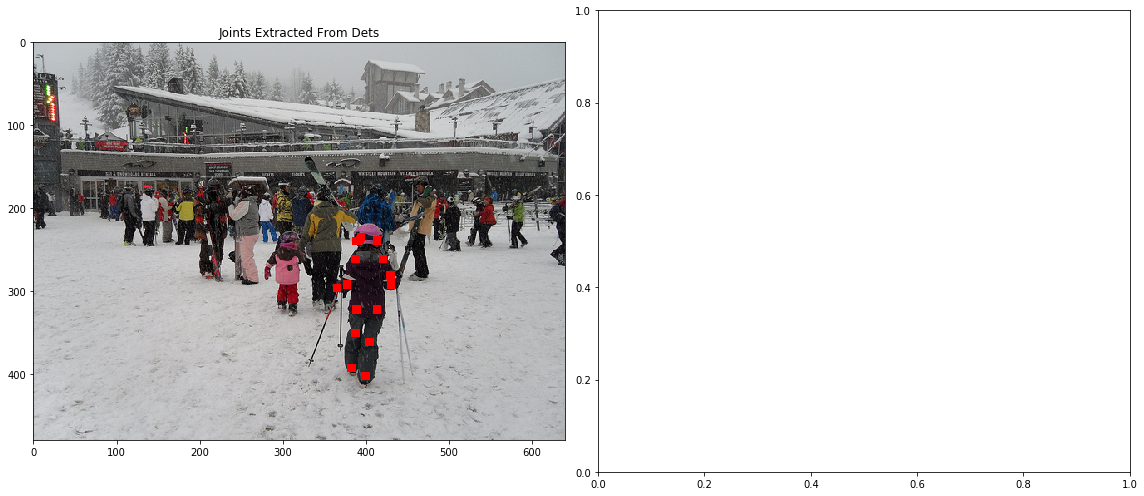

In [56]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,7)
zoom = 5

for idx in range(1):
    cur_img = np.array(full_imgs[idx,:].cpu())
#     cur_img = np.array(imgs[idx,:].cpu())
    aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
    aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
    aux_img = np.round(aux_img).astype(int)
    aux = np.copy(aux_img)
    
    for i, k in enumerate(keypoints[idx,:]):
#         print(k)
        if(len(k) > 0):
            aux[k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom,0] = 255
            aux[k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom,1] = 0
            aux[k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom,2] = 0
    ax[idx].imshow(aux)
    ax[idx].set_title("Joints Extracted From Dets")

plt.tight_layout()
plt.show()

In [57]:
pose_entries, all_keypoints = pose_parsing.create_pose_entries(keypoints)

pose_entries = [pose_entries]
all_keypoints = [all_keypoints[:, 1], all_keypoints[:, 0], all_keypoints[:, 2], all_keypoints[:, 3]]
all_keypoints = np.array(all_keypoints).T
print(all_keypoints.shape)

(17, 4)


In [58]:
pose_parsing.SKELETON = CONSTANTS.SKELETON_HRNET
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False

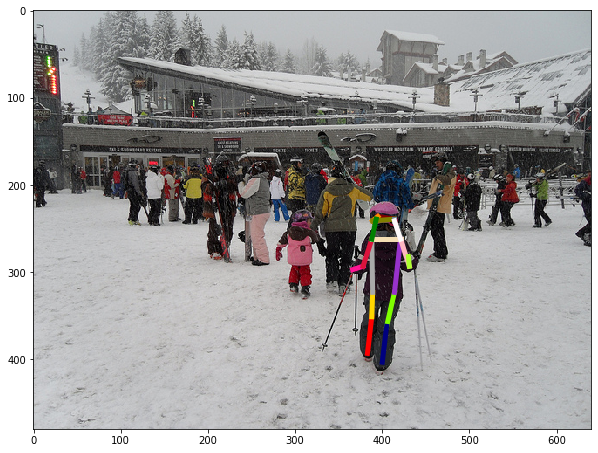

In [59]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,8)

title = "Pose from Detections"
visualizations.draw_pose(np.array(full_imgs[0,:]), pose_entries[0], all_keypoints, ax=ax, title=title)

# title = "Pose from Detections"
# visualizations.draw_pose(np.array(full_imgs[1,:]), pose_entries[1], all_keypoints, ax=ax[1], title=title)


# Saving Predictions

In [69]:
n_imgs = len(metadata["image"])

In [70]:
# saving predictions
all_preds = np.zeros((n_imgs, 17, 3), dtype=np.float32)
all_preds[:,:,:2] = keypoints[:,:,:2]
all_preds[:,:,2:3] = max_vals

In [71]:
# saving bounding boxes
all_boxes = np.zeros((n_imgs, 6))
all_boxes[:, 0:2] = centers[:, 0:2]
all_boxes[:, 2:4] = scales[:, 0:2]
all_boxes[:, 4] = np.prod(scales*200, 1)
all_boxes[:, 5] = score

In [72]:
data_path = CONFIG["paths"]["data_path"]
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_validation.json")
preds_file = os.path.join(test_exp, CONFIG["paths"]["submission"])

In [73]:
utils.reset_predictions_file(test_exp)
metrics.generate_submission_hrnet(all_preds, all_boxes, metadata, preds_file)

In [74]:
stats = metrics.compute_precision(labels_file=labels_file, preds_file=preds_file)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.129
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.125
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | m

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 